In [319]:
import numpy as np
import matplotlib.pyplot as plt

RNG = np.random.default_rng(42) # Random generator for reprodoctubility

## Data import

In [320]:
# Configuraciones para diferentes posiciones de las anclas (referencias):
# "pos": indica coordenadas cartesianas (m)
# "angulo": indica el ángulo del ancla respecto de la vertical (rad)

config_1 = {
"P1":{"pos": (56.69873, 75.0),"angulo": -1.0471975493043784},
"P2":{"pos": (94.770655, 109.771682),"angulo": -0.08726646965814552},
"P3":{"pos": (135.355339, 85.355339),"angulo": 0.7853981633974481}
}

config_2 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (34.467836, 95.886115),"angulo": -0.9599310909314129},
"P3":{"pos": (39.818498, 129.863551),"angulo": -0.6457718207490258}
}

config_3 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (40.548414, 103.530449),"angulo": -0.8377580360740813},
"P3":{"pos": (35.721239, 126.604444),"angulo": -0.6981317030426971}
}

config_4 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (43.332813, 106.469726),"angulo": -0.7871434894299918},
"P3":{"pos": (29.412843, 120.833984),"angulo": -0.7836528320585269}
}

# Posición esperada para el objetivo
p = (100, 50)


In [321]:
# Every import to numpy

theta_1 = np.array([config_1[p]['angulo'] for p in config_1.keys()])
pos_1   = np.array([config_1[p]['pos']    for p in config_1.keys()])

theta_2 = np.array([config_2[p]['angulo'] for p in config_2.keys()])
pos_2   = np.array([config_2[p]['pos']    for p in config_2.keys()])

theta_3 = np.array([config_3[p]['angulo'] for p in config_3.keys()])
pos_3   = np.array([config_3[p]['pos']    for p in config_3.keys()])

theta_4 = np.array([config_4[p]['angulo'] for p in config_4.keys()])
pos_4   = np.array([config_4[p]['pos']    for p in config_4.keys()])

angles_clean = np.stack([theta_1, theta_2, theta_3, theta_4])
positions_clean = np.stack([pos_1, pos_2, pos_3, pos_4])

# 1. Matemathical Model

$$
A =
\begin{pmatrix}
\cos\theta_1 & -\sin\theta_1 \\
\cos\theta_2 & -\sin\theta_2 \\
\vdots       & \vdots        \\
\cos\theta_i & -\sin\theta_i
\end{pmatrix}
\qquad
p =
\begin{pmatrix}
x \\
y
\end{pmatrix}
\qquad
b =
\begin{pmatrix}
x_1\cos\theta_1 - y_1\sin\theta_1 \\
x_2\cos\theta_2 - y_2\sin\theta_2 \\
\vdots                                \\
x_i\cos\theta_i - y_i\sin\theta_i
\end{pmatrix}
$$

Dado que el sistema es sobredeterminado, donde se toman 3 mediciones por configuración, la solución estimada se obtiene mediante mínimos cuadrados:


$$ \hat p = (A^\top A)^{-1} A^\top b $$

En la práctica, las mediciones angulares están afectadas por ruido. Cada ángulo observado se modela como

$$
\theta_i^{\text{obs}} = \theta_i + \varepsilon_i
\qquad 
\varepsilon_i \sim \mathcal N(0,\sigma^2)
$$

de modo que las matrices $A$ y $b$ utilizadas en la estimación se construyen a partir de $\theta_i^{\text{obs}}$
y no de los valores verdaderos. La estabilidad del estimador de mínimos cuadrados depende críticamente del
número de condición de la matriz de diseño,


$$ \kappa(A) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)} $$


In [322]:
def estimate_p(angles, positions):
    A = np.column_stack([np.cos(angles), -np.sin(angles)])    # Design matrix
    b = np.sum(A * positions, axis = 1) # Solutions for linear system
    x, *_ = np.linalg.lstsq(A, b, rcond=None)  # Least Squares solution
    return  x, np.linalg.cond(A)

# 2. Simulation

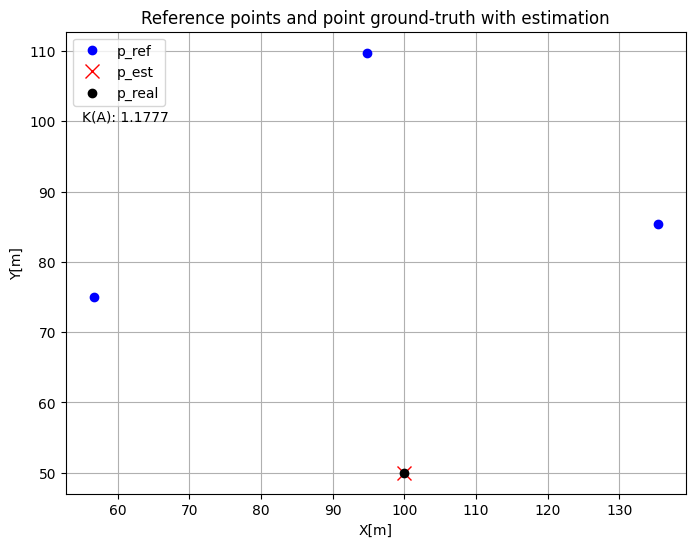

In [323]:
x, cond = estimate_p(theta_1, pos_1)

plt.figure(figsize=(8,6))
plt.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
plt.plot(x[0], x[1], 'x', markersize=10.0, color='red', label='p_est')
plt.plot(p[0], p[1], 'o', color='black', label='p_real')
plt.title('Reference points and point ground-truth with estimation')
plt.text(55, 100, f'K(A): {cond:.4f}')
plt.legend(loc='upper left')
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.grid(True)
plt.show()

### Coordenadas ruidosas

$$
\tilde p_i = (x_i + \Delta x_i,\; y_i + \Delta y_i)
\qquad
\Delta x_i \sim \mathcal N(0,\sigma^2)
\qquad
\Delta y_i \sim \mathcal N(0,\sigma^2)
$$

In [324]:
def generate_gaussian_noisy_samples(reference_tensor, sigma, num_samples, axis, rng):
    """
    Insert a new axis into `reference_tensor`, tile it `num_samples` times
    along that axis, and add Gaussian noise.

    Parameters:
        reference_tensor : np.ndarray
            Original data of any shape.
        sigma : float
            Standard deviation of Gaussian noise.
        num_samples : int
            Number of noisy replicas along the new axis.
        axis : int, default 0
            Axis where the new dimension will be inserted.
        rng : np.random.Generator, optional
            Random generator.

    Returns:
        np.ndarray
            Array of shape obtained by inserting axis with size num_samples.
    """
    # Make memory layout deterministic
    reference_tensor = np.ascontiguousarray(reference_tensor)

    # Insert a new axis
    expanded = np.expand_dims(reference_tensor, axis=axis)

    # Tile the data along the new axis
    tile_shape = [1] * expanded.ndim
    tile_shape[axis] = num_samples
    tiled = np.tile(expanded, tile_shape)

    # Generate noise with identical shape
    noise = rng.normal(0, sigma, size=tiled.shape)

    return tiled + noise

def estimate_p_batches(angles, positions):
    """
    angles: shape (3,)
    positions: shape (N,3,2)
    returns:
        p_global: shape (2,)
        condA: condition number of A
    """
    # Base A matrix (same for all samples)
    A = np.column_stack([np.cos(angles), -np.sin(angles)])  # (3,2)
    condA = np.linalg.cond(A)

    N = positions.shape[0]  # number of samples (50)

    # Expand A to match all samples:
    A_big = np.repeat(A[None, :, :], N, axis=0)  # (50, 3, 2)
    A_big = A_big.reshape(N * 3, 2)              # (150, 2)

    # Build big b vector
    x = positions[:,:,0]  # (50,3)
    y = positions[:,:,1]  # (50,3)

    b = x * np.cos(angles) - y * np.sin(angles)   # (50,3)
    b_big = b.reshape(N * 3)                      # (150,)

    # Solve global LS system
    p_global, *_ = np.linalg.lstsq(A_big, b_big, rcond=None)

    return p_global, condA

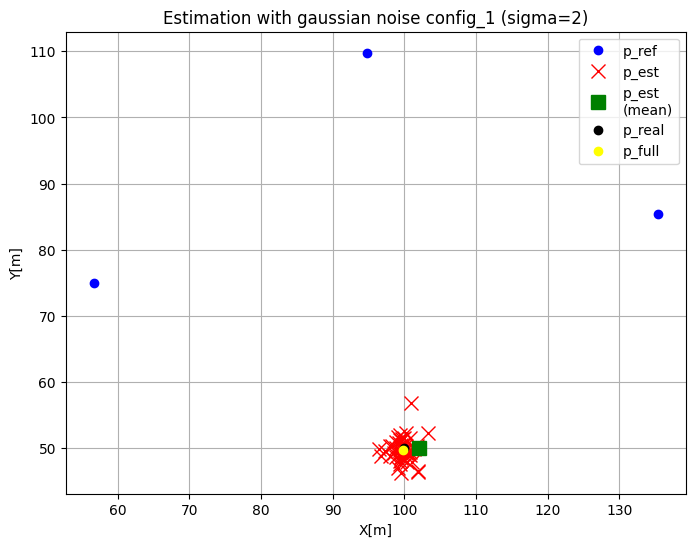

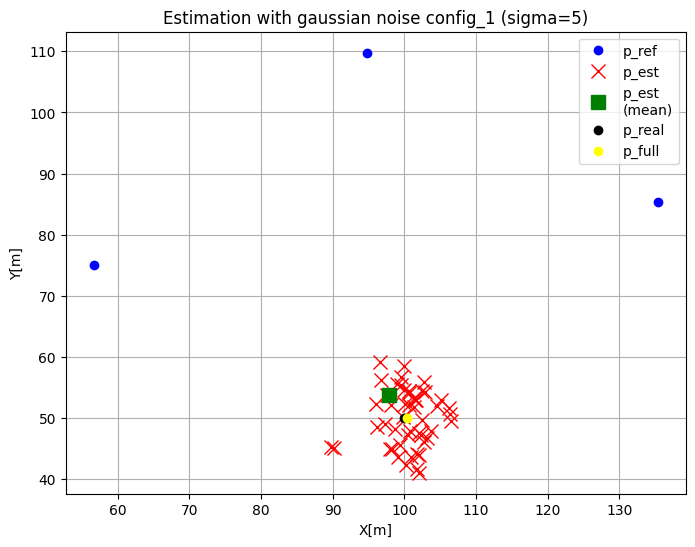

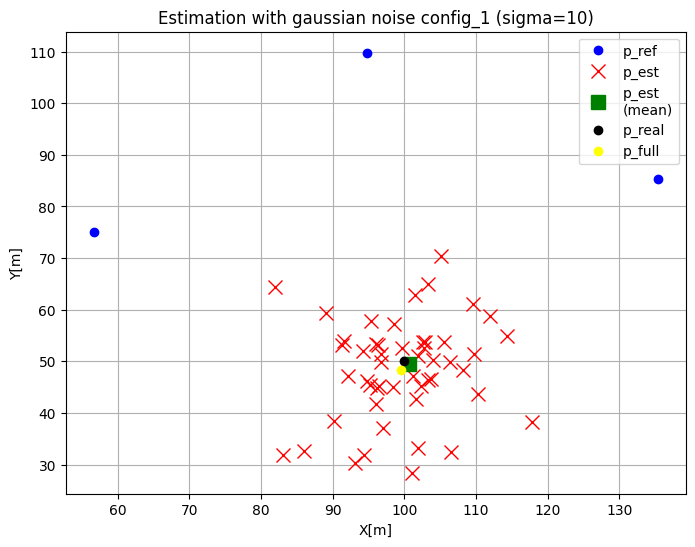

In [325]:
# Introducing gaussian noise to reference points's coordinates
SAMPLES = 50

sigmas = (2, 5, 10)
estimations = np.zeros((3, SAMPLES, 2))
full = np.zeros((3,2))
for k in range(len(sigmas)):
    noisy_sampling = generate_gaussian_noisy_samples(pos_1, sigmas[k], SAMPLES, 0, RNG)
    full[k], _ = estimate_p_batches(theta_1, noisy_sampling)
    for i in range(noisy_sampling.shape[0]):
        x, _ = estimate_p(theta_1, noisy_sampling[i])
        estimations[k, i] = x

for i in range(estimations.shape[0]):
    plt.figure(figsize=(8,6))
    plt.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
    plt.plot(estimations[i,:,0], estimations[i,:,1], 'x', markersize=10.0, color='red', label='p_est')
    plt.plot(np.mean(estimations[:,i,0]), np.mean(estimations[:,i,1]), 's', markersize=10.0, color='green', label='p_est\n(mean)')
    plt.plot(p[0], p[1], 'o', color='black', label='p_real')
    plt.plot(full[i,0],full[i,1], 'o', color='yellow', label='p_full')
    plt.title(f'Estimation with gaussian noise config_1 (sigma={sigmas[i]})')
    plt.legend(loc='upper right')
    plt.xlabel('X[m]')
    plt.ylabel('Y[m]')
    plt.grid(True)
    plt.show()

###  Mediciones angulares afectadas por ruido

$$
\theta_i^{\text{obs}} = \theta_i + \varepsilon_i
\qquad 
\varepsilon_i \sim \mathcal N(0,\sigma^2)
$$


[[ 24.49717099 -24.58104065]
 [ 22.3076717  -22.63302711]
 [-96.04920916  96.45843422]]


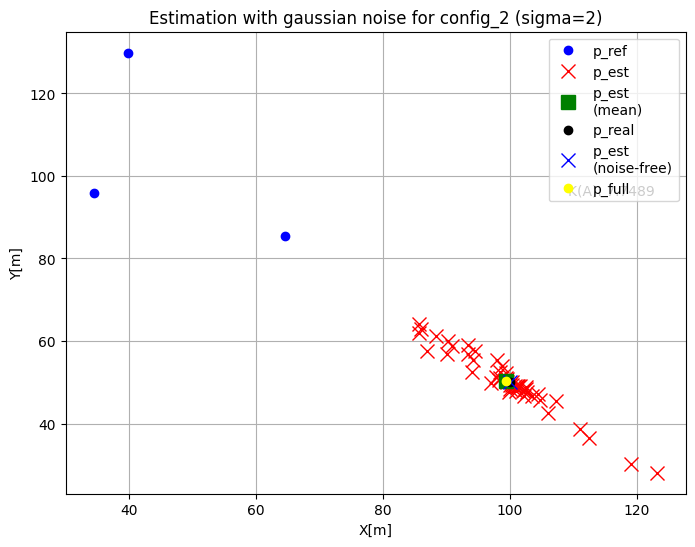

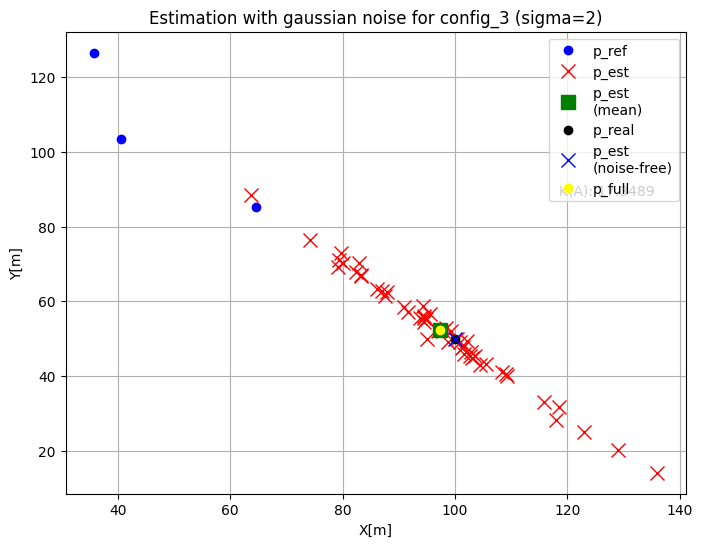

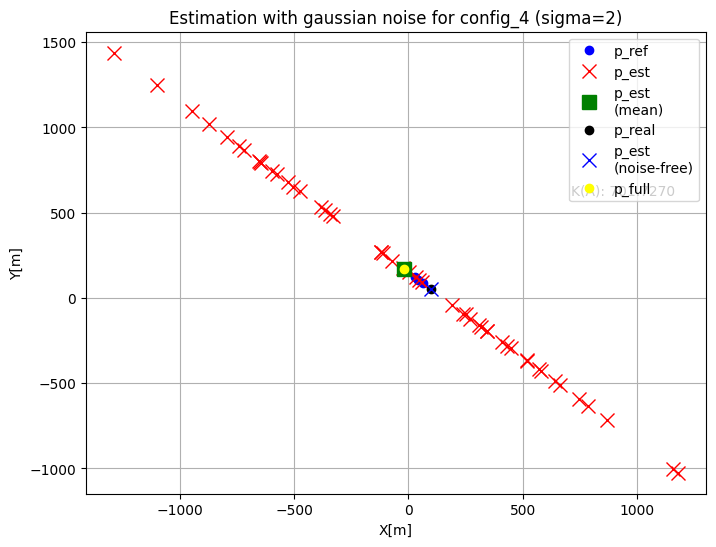

In [ ]:
# Introducing gaussian noise into observed angles
angles_234 = np.array(angles_clean[1:,:])
pos_234 = np.array(positions_clean[1:,:])
# First we get the solution without noise and condition number of design matrix for a later comparison
sigma = 2
conditions = np.zeros(3)
clean_solutions = np.zeros((3, 2))
full = np.zeros((3,2))
estimations = np.zeros((SAMPLES, 3, 2))
noisy_pos = generate_gaussian_noisy_samples(pos_234, sigma, SAMPLES, 1, RNG)
for config in range(3):
    clean_solutions[config], conditions[config] = estimate_p(angles_234[config], pos_234[config])
    full[config], _ = estimate_p_batches(angles_234[config], noisy_pos[config])
    for sample in range(SAMPLES):
        x, _ = estimate_p(angles_234[config], noisy_pos[config, sample])
        estimations[sample, config] = x

for i in range(3):
    plt.figure(figsize=(8,6))
    plt.plot(pos_234[i,:,0], pos_234[i,:,1], 'o', color='blue', label='p_ref')
    plt.plot(estimations[:,i,0], estimations[:,i,1], 'x', markersize=10.0, color='red', label='p_est')
    plt.plot(np.mean(estimations[:,i,0]), np.mean(estimations[:,i,1]), 's', markersize=10.0, color='green', label='p_est\n(mean)')
    plt.plot(p[0], p[1], 'o', color='black', label='p_real')
    plt.plot(clean_solutions[i][0], clean_solutions[i][1], 'x', markersize=10.0, color='blue', label='p_est\n(noise-free)')
    plt.plot(full[i,0],full[i,1], 'o', color='yellow', label='p_full')
    plt.title(f'Estimation with gaussian noise for config_{i+2} (sigma={sigma})')
    leg = plt.legend(loc='upper right')
    # For text alignment
    plt.gcf().canvas.draw()
    bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())
    plt.text(0.95, 0.67, f'K(A): {conditions[i]:.4f}', transform=plt.gca().transAxes, ha='right', va='top')
    plt.xlabel('X[m]')
    plt.ylabel('Y[m]')
    plt.grid(True)
    plt.show()

In [327]:
sigma = 0.01


N_CONFIGS = 4

def noisy_angles(angles):
    return angles + RNG.normal(0, sigma, size=angles.shape)

# 1) Clean solutions and clean matrices
x_clean = np.zeros((N_CONFIGS, 2))
clean_cond = np.zeros(N_CONFIGS)
clean_As = []

for j in range(N_CONFIGS):
    xc, condA, A_clean = estimate_p(angles_clean[j], positions_clean[j])
    x_clean[j] = xc
    clean_cond[j] = condA
    clean_As.append(A_clean)

# 2) Storage for Monte Carlo
cond_values = np.zeros((SAMPLES, N_CONFIGS))
A_diff_norm = np.zeros((SAMPLES, N_CONFIGS))
x_diff_norm = np.zeros((SAMPLES, N_CONFIGS))
x_diff_rel  = np.zeros((SAMPLES, N_CONFIGS))

# 3) Monte Carlo loop
for s in range(SAMPLES):
    noisy = noisy_angles(angles_clean)

    for j in range(N_CONFIGS):
        x_noisy, condA, A_noisy = estimate_p(noisy[j], positions_clean[j])

        cond_values[s, j] = condA
        A_diff_norm[s, j] = np.linalg.norm(A_noisy - clean_As[j], ord='fro')

        dx = x_noisy - x_clean[j]
        x_diff_norm[s, j] = np.linalg.norm(dx)
        x_diff_rel[s, j]  = x_diff_norm[s, j] / np.linalg.norm(x_clean[j])

# ---------- PLOTS ----------

# Plot 1: norm(A_noisy - A_clean)
plt.figure(figsize=(10,6))
for j in range(N_CONFIGS):
    plt.plot(A_diff_norm[:, j], label=f"Config {j+1} (mean cond ≈ {np.mean(cond_values[:,j]):.1f})")
plt.xlabel("Sample index")
plt.ylabel("Frobenius norm of A_noisy - A_clean")
plt.title("Change in design matrix A across noise samples")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: norm(x_noisy - x_clean)
plt.figure(figsize=(10,6))
for j in range(N_CONFIGS):
    plt.plot(x_diff_norm[:, j], label=f"Config {j+1} (mean cond ≈ {np.mean(cond_values[:,j]):.1f})")
plt.xlabel("Sample index")
plt.ylabel("Euclidean norm of x_noisy - x_clean")
plt.title("Change in estimated point x across noise samples")
plt.grid(True)
plt.legend()
plt.show()

# Plot 3: cond(A) vs ||x_noisy - x_clean||
plt.figure(figsize=(10,6))
for j in range(N_CONFIGS):
    plt.scatter(cond_values[:, j], x_diff_norm[:, j], label=f"Config {j+1}")
plt.xlabel("Condition number of A")
plt.ylabel("||x_noisy - x_clean||")
plt.title("Solution sensitivity vs condition number")
plt.grid(True)
plt.legend()
plt.show()

# Optional: relative error plot (log-scale helps)
plt.figure(figsize=(10,6))
for j in range(N_CONFIGS):
    plt.scatter(cond_values[:, j], x_diff_rel[:, j], label=f"Config {j+1}")
plt.xlabel("Condition number of A")
plt.ylabel("Relative error in x")
plt.yscale("log")
plt.title("Relative error of x vs condition number (log scale)")
plt.grid(True, which='both')
plt.legend()
plt.show()

print("\nMean condition numbers per config:", np.mean(cond_values, axis=0))

ValueError: not enough values to unpack (expected 3, got 2)